To take advantage of the temporal aspect of the data, we will split the dataset into 2 separate time periods for training and testing data:
* Training Data: February (2017/02/01 - 2017/02/28)
* Testing Data: March (2017/03/01 - 2017/03/31)

In [83]:
# Load Libraries
import pandas as pd
import time
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing <br>

Both the training data and the testing data are biased towards user who did not churn. To balance it out, both need to be downsampled. Previously we had already downsampled the churn data for February. We also have to do it for our churn data for March.

In [2]:
feb_churn = pd.read_csv('./EDA_Data/train_modified.csv')
march_churn = pd.read_csv('./Data2/train_v2.csv')

In [9]:
feb_churn.describe()

,is_churn
count,138471.000000
mean,0.458370
std,0.498266
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
march_churn.describe()

,is_churn
count,970960.000000
mean,0.089942
std,0.286099
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
np.sum(march_churn.is_churn == 1)

87330

In [3]:
#Split train data into churn and no churn dataframes
train_churn = march_churn[march_churn.is_churn == 1]
train_nochurn = march_churn[march_churn.is_churn == 0]

#Sample nochurn group
nochurn_sample = train_nochurn.msno.sample(n=87500, random_state=3).tolist()
train_nochurn = march_churn[march_churn.msno.isin(nochurn_sample)]

#Combine the two dataframes
march_churn = pd.concat([train_churn, train_nochurn])
march_churn.reset_index(drop=True, inplace=True)

In [5]:
march_churn.describe()

,is_churn
count,174830.000000
mean,0.499514
std,0.500001
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Now, the test data is also balanced out with ~50% churn rate compared to the previous 9% churn rate.

## Feature Engineering
### Member Data
We will need to convert all the categorical data into dummy variables. The categorical data includes:
* City
* Gender
* Registration Method

As well as creating a variable that turns registration initiation date into a relative feature. This means that we will find the difference between the registration initiation date and the end date of the time period.

**Train Data: February**

In [4]:
# Read Member data file
feb_members = pd.read_csv('./EDA_Data/members_modified.csv')

# Convert Registration into date time object
feb_members['registration_init_time'] = pd.to_datetime(feb_members.registration_init_time)

# Convert columns into categorical data
cat_list = ['city', 'gender', 'registered_via']
for col in cat_list:
    feb_members[col] = feb_members[col].astype('category')
    
# Converting categorical data into dummy variables
feb_cat_data = feb_members[cat_list]
feb_cat_data = pd.get_dummies(feb_cat_data, drop_first = True).to_sparse(fill_value=0)
feb_cat_data['msno'] = feb_members.msno

# Create Days since registration feature
feb_cat_data['days_since_reg'] = feb_members.registration_init_time.apply(lambda x: (pd.Timestamp(2017,2,28) - x).days)

# Add Age data
feb_cat_data['age'] = feb_members['bd']

feb_cat_data.head()

,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,...,city_21,city_22,gender_male,registered_via_4,registered_via_7,registered_via_9,registered_via_13,msno,days_since_reg,age
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,WH5Jq4mgtfUFXh2yz+HrcTXKS4Oess4k4W3qKolAeb0=,1992,34.0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,Z6WIOK9vXy+e2XDBiioNAxuZ0ScXSU/Ebq4tUwqVSrE=,1979,38.0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,i4kmzPli+nl4XagzznO+oCcPeXfjcLSKIn8xE9oGU5E=,1972,58.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7oCpSPj4+SdVJLfDRc+tN5HLp2R1DRozaWsTpbLTz5g=,862,21.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,bPHi7VPQkMtdeIqJAktzYSITpRSt9F9mCdhddPTSlOY=,861,17.0


**Test Data: March**

In [5]:
# Load member data for test data
march_members = pd.read_csv('./Data/members_v3.csv')
march_members = march_members[march_members.msno.isin(march_churn.msno.tolist())]
march_members.reset_index(drop=True, inplace=True)
march_members.registration_init_time = march_members.registration_init_time.apply(lambda x: pd.to_datetime(datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None))

In [6]:
# Convert Registration into date time object
march_members['registration_init_time'] = pd.to_datetime(march_members.registration_init_time)

# Convert columns into categorical data
cat_list = ['city', 'gender', 'registered_via']
for col in cat_list:
    march_members[col] = march_members[col].astype('category')
    
# Converting categorical data into dummy variables
march_cat_data = march_members[cat_list]
march_cat_data = pd.get_dummies(march_cat_data, drop_first = True).to_sparse(fill_value=0)
march_cat_data['msno'] = march_members.msno

# Create Days since registration feature
march_cat_data['days_since_reg'] = march_members.registration_init_time.apply(lambda x: (pd.Timestamp(2017,3,31) - x).days)

# Add Age data
march_cat_data['age'] = march_members.bd.apply(lambda x: int(x) if x in range(1,101) else None)

march_cat_data.head()

,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,...,city_21,city_22,gender_male,registered_via_4,registered_via_7,registered_via_9,registered_via_13,msno,days_since_reg,age
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,2023,30.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,2021,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,Z6WIOK9vXy+e2XDBiioNAxuZ0ScXSU/Ebq4tUwqVSrE=,2010,38.0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,XmV2kHCnqnQf4oTJ4LCS7F02cpxnzqGIDDRGHe4dw8c=,2003,31.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,75A0yqLXt/ZZ+DY30gjRr/mJG8rDOexVswfVw1dVbt0=,1999,21.0


### Transactions Data

We will only use transactions data 3 months before the month of interest. For example, for the train data, we will only consider transactions from 11/01/2016 - 01/31/2017.

New features to be created include:

* dummy variables for type of payment plan (7 or 30)
* \# of transactions made
* average auto renew rate
* average actual paid
* average discount received
* average cancelled rate

**Train Transactions Data**

In [7]:
# Load data
train_trans = pd.read_csv('./EDA_Data/transactions_modified.csv')

# Convert transaction date into date time object
train_trans['transaction_date'] = pd.to_datetime(train_trans.transaction_date)

# Filter November - January
train_trans = train_trans.loc[(train_trans.transaction_date <= '01-31-2017') & (train_trans.transaction_date >= '11-01-2016')]

In [8]:
# Payment Plan dummies
train_trans['payment_plan_7'] = (train_trans.payment_plan_days == 7) * 1
train_trans['payment_plan_30'] = (train_trans.payment_plan_days == 30) * 1

# Discounts Received
train_trans['discount_received'] = train_trans.plan_list_price - train_trans.actual_amount_paid

In [9]:
# Finding aggregrated average
agg_train_trans = train_trans.groupby(['msno']).mean().reset_index()
agg_train_trans = agg_train_trans.drop(['payment_method_id', 'plan_list_price', 'payment_plan_days'], axis = 1)

new_col = ['msno']
new_col.extend('avg_' + agg_train_trans.columns[1:])

agg_train_trans.columns = new_col

# Transactions count 
agg_train_trans['trans_count'] = train_trans.groupby(['msno']).size().reset_index()[0]

In [12]:
agg_train_trans.head()

,msno,avg_actual_amount_paid,avg_is_auto_renew,avg_is_cancel,avg_payment_plan_7,avg_payment_plan_30,avg_discount_received,trans_count
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,149.0,1.0,0.0,0.0,1.0,0.0,3
1,++3A6JMzYJeron30GTcDostfXoAl8rTBuB2M8GeVdNU=,149.0,1.0,0.0,0.0,1.0,0.0,3
2,++57miEuSte1zcmehY9pZ1u9mZAqA3wX4h6CA5L17SA=,149.0,0.0,0.0,0.0,1.0,0.0,2
3,++BBU1qnsavj2eC5j5G6dTda9ntLhRiz+pidG73im5s=,149.0,1.0,0.0,0.0,1.0,0.0,3
4,++CITmZPtQDWOi01uceGb75QJblInDRhjjGM1MmsiSY=,149.0,1.0,0.0,0.0,1.0,0.0,3


**Test Transactions Data**

In [10]:
# Load Data
test_trans = pd.DataFrame()
chunksize = 100000
for chunk in pd.read_csv('./Data2/transactions.csv', chunksize=chunksize):
    df = chunk[chunk.msno.isin(march_churn.msno.tolist())]
    test_trans = test_trans.append(df)
test_trans.reset_index(drop=True, inplace=True)

In [11]:
# Convert transaction date into date time object
test_trans['transaction_date'] = test_trans.transaction_date.apply(lambda x: pd.to_datetime(datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None))

# Filter December - February
test_trans = test_trans.loc[(test_trans.transaction_date <= '02-28-2017') & (test_trans.transaction_date >= '12-01-2016')]

In [12]:
# Payment Plan dummies
test_trans['payment_plan_7'] = (test_trans.payment_plan_days == 7) * 1
test_trans['payment_plan_30'] = (test_trans.payment_plan_days == 30) * 1

# Discounts Received
test_trans['discount_received'] = test_trans.plan_list_price - test_trans.actual_amount_paid

# Finding aggregrated average
agg_test_trans = test_trans.groupby(['msno']).mean().reset_index()
agg_test_trans = agg_test_trans.drop(['payment_method_id', 'plan_list_price', 'payment_plan_days', 'membership_expire_date'], axis = 1)

new_col = ['msno']
new_col.extend('avg_' + agg_test_trans.columns[1:])

agg_test_trans.columns = new_col

# Transactions count 
agg_test_trans['trans_count'] = test_trans.groupby(['msno']).size().reset_index()[0]

In [16]:
agg_test_trans.head()

,msno,avg_actual_amount_paid,avg_is_auto_renew,avg_is_cancel,avg_payment_plan_7,avg_payment_plan_30,avg_discount_received,trans_count
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,99.0,1.0,0.0,0.0,1.0,0.0,3
1,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,149.0,1.0,0.0,0.0,1.0,0.0,2
2,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,99.0,1.0,0.0,0.0,1.0,0.0,3
3,++2Ju1OdxLSyexwhZ/C0glNK0DMIfUjsFpk9lt8Dll8=,99.0,1.0,0.0,0.0,1.0,0.0,3
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,149.0,1.0,0.0,0.0,1.0,0.0,3


### User Log Data

We will look at user behavior the month before month of interest. Therefore, for February churn data, we will look at the activity log for January.

New features to be created include:
* Days since last log in 
* activity logged for month
* mean number of songs per month according to % of song listened
* mean rate of songs
* total seconds for month
* mean unique songs listened per session

**Train User Log Data**

In [13]:
# Load data
train_user_logs = pd.read_csv('./EDA_Data/user_logs_modified.csv')

# Convert transaction date into date time object
train_user_logs['date'] = pd.to_datetime(train_user_logs.date)

# Filter January
train_user_logs = train_user_logs.loc[(train_user_logs.date <= '01-31-2017') & (train_user_logs.date >= '01-01-2017')]

In [14]:
# Days since last log-in
last_login = train_user_logs.sort_values(by='date', ascending=False)
last_login.drop_duplicates(subset = ['msno'], keep='first', inplace = True)
last_login['days_since_login'] = last_login.date.apply(lambda x: (pd.Timestamp(2017,1,31) - x).days)
last_login = last_login[['msno', 'days_since_login']]

In [15]:
# Rate of songs
num_list = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100']

for num in num_list:
    colname = 'rate_' + num
    train_user_logs[colname] = train_user_logs[num] / train_user_logs[num_list].sum(axis=1)

In [16]:
# Average aggregates
agg_train_user_logs = train_user_logs.groupby(['msno']).mean().reset_index()
agg_train_user_logs = agg_train_user_logs.drop(['total_secs'], axis=1)
new_col = ['msno']
new_col.extend('avg_' + agg_train_user_logs.columns[1:])

agg_train_user_logs.columns = new_col

# Total Seconds Listened
agg_train_user_logs['total_secs'] = train_user_logs[['msno', 'total_secs']].groupby(['msno']).sum().reset_index()['total_secs']

# Log count
agg_train_user_logs['log_count'] = train_user_logs.groupby(['msno']).size().reset_index()[0]

# Merge with last login
agg_train_user_logs = pd.merge(left=agg_train_user_logs, right = last_login, on=['msno'])

In [213]:
agg_train_user_logs.head()

,msno,avg_num_25,avg_num_50,avg_num_75,avg_num_985,avg_num_100,avg_num_unq,avg_rate_num_25,avg_rate_num_50,avg_rate_num_75,avg_rate_num_985,avg_rate_num_100,total_secs,log_count,days_since_login
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,13.538462,6.384615,3.461538,2.846154,28.153846,47.384615,0.192707,0.090342,0.050522,0.058059,0.608369,114372.977,13,18
1,++3A6JMzYJeron30GTcDostfXoAl8rTBuB2M8GeVdNU=,2.769231,1.307692,0.538462,0.230769,19.538462,21.384615,0.101807,0.028927,0.015999,0.007223,0.846044,62019.975,13,3
2,++BBU1qnsavj2eC5j5G6dTda9ntLhRiz+pidG73im5s=,10.000000,4.000000,2.250000,1.500000,150.500000,108.500000,0.061138,0.025993,0.013027,0.008687,0.891155,142027.073,4,0
3,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,4.000000,2.000000,1.000000,1.000000,31.000000,32.000000,0.102564,0.051282,0.025641,0.025641,0.794872,8437.787,1,29
4,++N9C3T2DFC2uRZ9LYOJW0KSq1sG++54neJYETDmkkI=,21.250000,4.000000,2.000000,2.750000,39.000000,41.500000,0.297542,0.070592,0.042423,0.043075,0.546368,43269.788,4,0


**Test User Log Data**

In [17]:
# Load Data
test_user_logs = pd.DataFrame()
chunksize = 100000
for chunk in pd.read_csv('./Data2/user_logs.csv', chunksize=chunksize):
    df = chunk[(chunk.msno.isin(march_churn.msno.tolist())) & (chunk.date >= 20170201)]
    test_user_logs = test_user_logs.append(df)
test_user_logs.reset_index(drop=True, inplace=True)

test_user_logs.date = test_user_logs.date.apply(lambda x: pd.to_datetime(datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else None))

In [18]:
# Days since last log-in
last_login = test_user_logs.sort_values(by='date', ascending=False)
last_login.drop_duplicates(subset = ['msno'], keep='first', inplace = True)
last_login['days_since_login'] = last_login.date.apply(lambda x: (pd.Timestamp(2017,2,28) - x).days)
last_login = last_login[['msno', 'days_since_login']]

# Rate of songs
num_list = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100']

for num in num_list:
    colname = 'rate_' + num
    test_user_logs[colname] = test_user_logs[num] / test_user_logs[num_list].sum(axis=1)

In [19]:
# Average aggregates
agg_test_user_logs = test_user_logs.groupby(['msno']).mean().reset_index()
agg_test_user_logs = agg_test_user_logs.drop(['total_secs'], axis=1)
new_col = ['msno']
new_col.extend('avg_' + agg_test_user_logs.columns[1:])

agg_test_user_logs.columns = new_col

# Total Seconds Listened
agg_test_user_logs['total_secs'] = test_user_logs[['msno', 'total_secs']].groupby(['msno']).sum().reset_index()['total_secs']

# Log count
agg_test_user_logs['log_count'] = test_user_logs.groupby(['msno']).size().reset_index()[0]

# Merge with last login
agg_test_user_logs = pd.merge(left=agg_test_user_logs, right = last_login, on=['msno'])

In [229]:
agg_test_user_logs.head()

,msno,avg_num_25,avg_num_50,avg_num_75,avg_num_985,avg_num_100,avg_num_unq,avg_rate_num_25,avg_rate_num_50,avg_rate_num_75,avg_rate_num_985,avg_rate_num_100,total_secs,log_count,days_since_login
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,3.750000,1.750000,2.000000,2.750000,8.250000,15.750000,0.177454,0.096097,0.137764,0.113060,0.475626,12555.289,4,23
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,23.000000,15.000000,5.000000,3.000000,16.000000,54.000000,0.370968,0.241935,0.080645,0.048387,0.258065,7436.634,1,1
2,++3wqX72HmowxFh5MrHvNi5Ce8D3ldo4zaUL932TYbs=,15.500000,3.916667,1.500000,1.333333,2.666667,21.750000,0.538051,0.178647,0.056028,0.053441,0.173833,19650.887,12,5
3,++95tJZADNg8U8HKbYdxbbXIRsO6pw1zBK4tHI7BtZo=,0.250000,0.250000,0.000000,0.500000,6.250000,6.500000,0.025000,0.025000,0.000000,0.093750,0.856250,7307.666,4,0
4,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,8.294118,2.176471,1.294118,1.882353,26.411765,30.705882,0.211964,0.047110,0.030209,0.066705,0.644013,107729.972,17,8


## Data Preprocessing

**Train Data**

In [20]:
# Merge all variables together
feb_df = pd.merge(left=feb_churn, right = feb_cat_data, on = 'msno', how = 'right')
feb_df = pd.merge(left=feb_df, right = agg_train_trans, on = 'msno', how = 'left')
feb_df = pd.merge(left=feb_df, right = agg_train_user_logs, on = 'msno', how = 'left')

# Fill in missing variables
feb_df['trans_count'].fillna(0, inplace=True)
feb_df['avg_payment_plan_30'].fillna(1, inplace=True)

from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(feb_df.iloc[:, 28:35])
feb_df.iloc[:, 28:35] = imputer.transform(feb_df.iloc[:, 28:35])

feb_df['log_count'].fillna(0, inplace=True)
feb_df['days_since_login'].fillna(31, inplace=True)

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(feb_df.iloc[:, 36:48])
feb_df.iloc[:, 36:48] = imputer.transform(feb_df.iloc[:, 36:48])

C:\Users\Iris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Iris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [310]:
y_feb = feb_df.iloc[:,1]
X_feb = feb_df.iloc[:,2:]

**Test Data**

In [22]:
# Merge all variables together
march_df = pd.merge(left=march_churn, right = march_cat_data, on = 'msno', how = 'right')
march_df = pd.merge(left=march_df, right = agg_test_trans, on = 'msno', how = 'left')
march_df = pd.merge(left=march_df, right = agg_test_user_logs, on = 'msno', how = 'left')

# Fill in missing variables
march_df['trans_count'].fillna(0, inplace=True)
march_df['avg_payment_plan_30'].fillna(1, inplace=True)

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(march_df.iloc[:, 28:35])
march_df.iloc[:, 28:35] = imputer.transform(march_df.iloc[:, 28:35])

march_df['log_count'].fillna(0, inplace=True)
march_df['days_since_login'].fillna(31, inplace=True)

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(march_df.iloc[:, 36:48])
march_df.iloc[:, 36:48] = imputer.transform(march_df.iloc[:, 36:48])

C:\Users\Iris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Iris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [23]:
y_march = march_df.iloc[:,1]
X_march = march_df.iloc[:,2:]

## Exploratory Data Analysis

In [150]:
feb_df.head()

,msno,is_churn,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,...,avg_num_100,avg_num_unq,avg_rate_num_25,avg_rate_num_50,avg_rate_num_75,avg_rate_num_985,avg_rate_num_100,total_secs,log_count,days_since_login
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,0,0,0,0,0,0,0,0,...,18.600000,21.000000,0.071185,0.022029,0.019785,0.006452,0.880549,25146.902000,5.0,2.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,0,0,0,0,0,0,0,1,...,27.221990,27.478360,0.183595,0.053127,0.035670,0.039990,0.687617,68266.082835,0.0,31.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,0,0,0,0,0,0,0,0,...,11.250000,15.375000,0.207590,0.037467,0.011364,0.201664,0.541916,23435.342000,8.0,0.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,0,0,0,0,0,0,0,0,...,15.647059,21.647059,0.247808,0.104739,0.055710,0.119971,0.471773,77083.611000,17.0,3.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,1,0,0,0,0,0,0,0,...,27.221990,27.478360,0.183595,0.053127,0.035670,0.039990,0.687617,68266.082835,0.0,31.0


In [151]:
feb_df.columns

Index(['msno', 'is_churn', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7',
       'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13',
       'city_14', 'city_15', 'city_16', 'city_17', 'city_18', 'city_19',
       'city_20', 'city_21', 'city_22', 'gender_male', 'registered_via_4',
       'registered_via_7', 'registered_via_9', 'registered_via_13',
       'days_since_reg', 'age', 'avg_actual_amount_paid', 'avg_is_auto_renew',
       'avg_is_cancel', 'avg_payment_plan_7', 'avg_payment_plan_30',
       'avg_discount_received', 'trans_count', 'avg_num_25', 'avg_num_50',
       'avg_num_75', 'avg_num_985', 'avg_num_100', 'avg_num_unq',
       'avg_rate_num_25', 'avg_rate_num_50', 'avg_rate_num_75',
       'avg_rate_num_985', 'avg_rate_num_100', 'total_secs', 'log_count',
       'days_since_login'],
      dtype='object')

Text(0.5, 1.0, 'Scatter-matrix for each input variable')

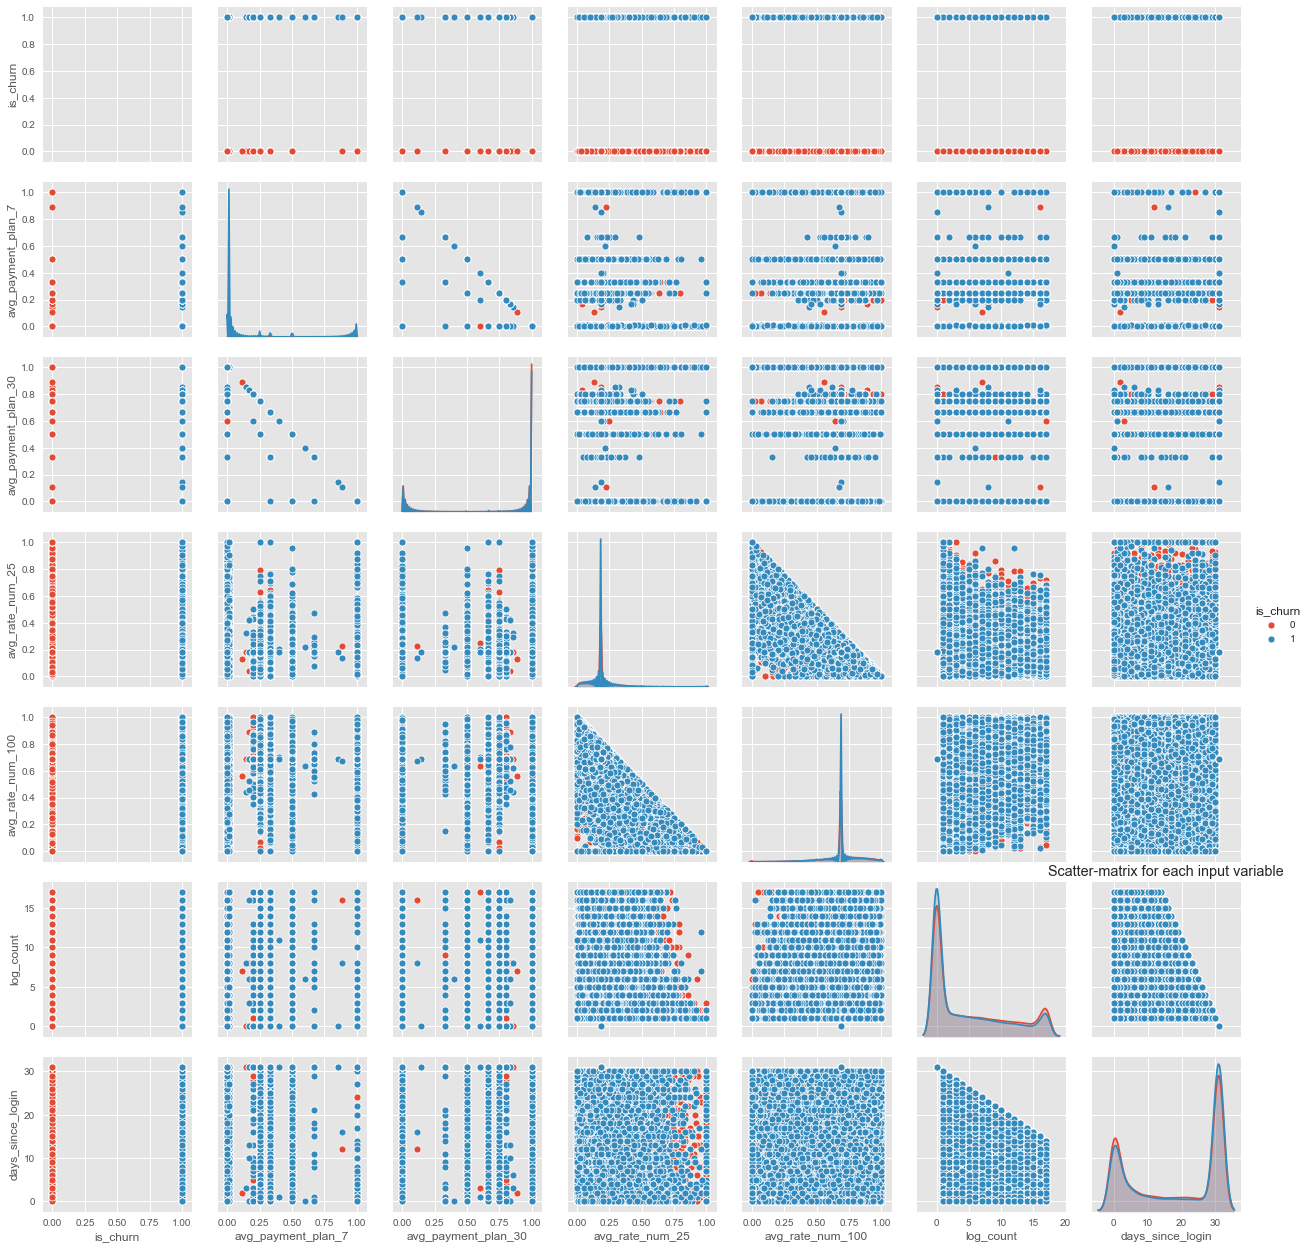

In [158]:
feature_names = ['is_churn','avg_payment_plan_7', 'avg_payment_plan_30', 'avg_rate_num_25', 'avg_rate_num_100', 'log_count', 'days_since_login']
X = feb_df[feature_names]
sns.pairplot(X, hue="is_churn")
plt.title('Scatter-matrix for each input variable')

## Classification Model

We use different classification model to see which default estimator works most effectively without tuning. We will then perform hyperparameter tuning on the most effective model. The metric used is the mean log loss for accuracy over 5-fold cross-validation because we want to be confident with our labels, not just accurate.

The training will be done on 80% of the data. The remaining 20% will be our hold-out set that will be left untouched until the final model has been selected and tuned. Since the range of values of the X features varies widely, we will normalize the data before training the model.

In [79]:
# Load libraries

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

#### Logistic Regression

In [37]:
# Build Model
from sklearn.model_selection import cross_val_score
clf = LogisticRegression()
steps = [('scaler', StandardScaler()),
         ('logreg', clf)]
pipeline = Pipeline(steps)

pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores = {}
scores["Logistic Regression"] = np.mean(cross_val_scores) * -1

print("Logistic Regression Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f"Average Score on 5-Folds: {(round(scores['Logistic Regression'],2))}")

Logistic Regression Cross-Validation Scores:
0.46
0.47
0.46
0.46
0.47
Average Score on 5-Folds: 0.46


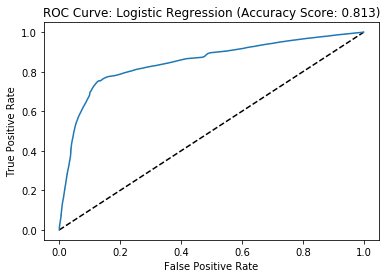

In [39]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: Logistic Regression (Accuracy Score: {round(pipeline.score(X_feb, y_feb),3)})')
plt.show()

In [40]:
pipeline.score(X_feb, y_feb)

0.8133021039454024

#### Random Forest

In [41]:
# Build Model
clf = RandomForestClassifier(random_state=42)
steps = [('scaler', StandardScaler()),
         ('RandomForest', clf)]
pipeline = Pipeline(steps)

#parameters = {'Classifier__n_estimators': [500,1000,100]}
pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores["Random Forest"] = np.mean(cross_val_scores) * -1

print("Random Forest Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f'Average Score on 5-Folds: {round(scores["Random Forest"],2)}')

Random Forest Cross-Validation Scores:
1.4
1.48
1.39
1.46
1.45
Average Score on 5-Folds: 1.44


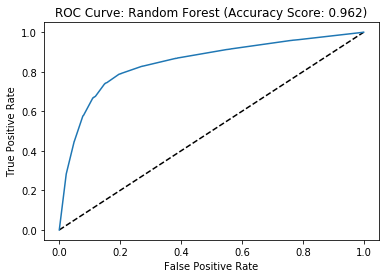

In [467]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: Random Forest (Accuracy Score: {round(pipeline.score(X_feb, y_feb), 3)})')
plt.show()

#### Adaptive Boosting Classifier

In [479]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=42)
steps = [('scaler', StandardScaler()),
         ('AdaBoost', clf)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores["AdaBoost"] = np.mean(cross_val_scores) * -1

print("AdaBoost Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f'Average Score on 5-Folds: {round(scores["AdaBoost"],2)}')

AdaBoost Cross-Validation Scores:
0.68
0.68
0.68
0.68
0.68
Average Score on 5-Folds: 0.68


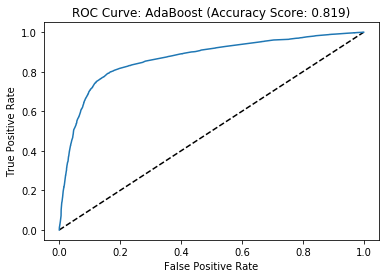

In [469]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: AdaBoost (Accuracy Score: {round(pipeline.score(X_feb, y_feb), 3)})')
plt.show()

#### Gradient Boosting Classifier

In [480]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=42)
steps = [('scaler', StandardScaler()),
         ('GradientBoost', clf)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores["GradientBoost"] = np.mean(cross_val_scores) * -1

print("GradientBoost Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f'Average Score on 5-Folds: {round(scores["GradientBoost"],2)}')

GradientBoost Cross-Validation Scores:
0.42
0.43
0.43
0.42
0.43
Average Score on 5-Folds: 0.43


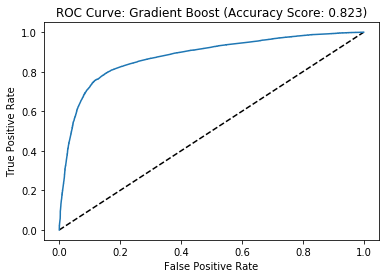

In [471]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: Gradient Boost (Accuracy Score: {round(pipeline.score(X_train, y_train), 3)})')
plt.show()

#### Extreme Gradient Boosting

In [481]:
from sklearn.ensemble import XGBClassifier
clf = XGBClassifier(random_state=42)
steps = [('scaler', StandardScaler()),
         ('XGradientBoost', clf)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb, y_feb)

cross_val_scores= cross_val_score(pipeline, X_feb, y_feb, cv=5, scoring='neg_log_loss')
scores["XGradientBoost"] = np.mean(cross_val_scores) * -1

print("XGradientBoost Cross-Validation Scores:")
for score in (cross_val_scores * -1):
    print(f'{round(score,2)}')
print(f'Average Score on 5-Folds: {round(scores["XGradientBoost"],2)}')

XGradientBoost Cross-Validation Scores:
0.42
0.43
0.43
0.42
0.43
Average Score on 5-Folds: 0.43


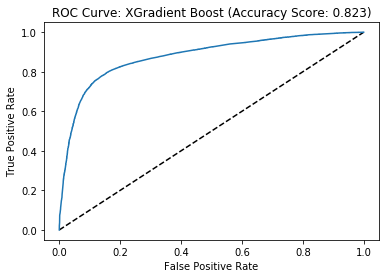

In [475]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_feb, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: XGradient Boost (Accuracy Score: {round(pipeline.score(X_feb, y_feb), 3)})')
plt.show()

In [488]:
scores = sorted(scores.items(), key=lambda score: score[1])

for i in range(len(scores)):
    print((scores[i][0], scores[i][1]))

('XGradientBoost', 0.4278696677673399)
('GradientBoost', 0.428462087175941)
('Logistic Regression', 0.4629922200086612)
('AdaBoost', 0.6816917932601727)
('Random Forest', 1.4643558751548718)


XGradientBoost seems to be the most effective model with the lowest log loss score of 0.427. However, Logistic Regression log loss score is fairly close. Therefore, we will hypertune the parameters of both classifers.

### Fine Tuning Hyperparameters

For the model that uses XGBoosting, we will be adjusting the following parameters:
* max_depth
* learning_rate
* colsample_bytree

In [495]:
model = XGBClassifier()
steps = [('scaler', StandardScaler()),
         ('XGB', model)]
pipeline = Pipeline(steps)

parameters = {'XGB__max_depth': range(6,11),
             'XGB__learning_rate': np.arange(0.01,0.11,.01),
             'XGB__colsample_bytree': np.arange(0.3, 0.9, 0.1)}

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'XGB__max_depth': range(6, 11), 'XGB__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]), 'XGB__colsample_bytree': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [496]:
cv.best_params_

{'XGB__colsample_bytree': 0.8000000000000003,
 'XGB__learning_rate': 0.05,
 'XGB__max_depth': 8}

In [183]:
cv.score(X_train, y_train)

NameError: name 'cv' is not defined

In [512]:
cross_val_score(final_model, X_train, y_train, cv=5, scoring='neg_log_loss')

array([-0.41379306, -0.42190345, -0.41630123, -0.41446563, -0.42198864])

In [522]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = cv.predict_proba(X_feb)[:,1]
log_loss(y_feb, y_pred_prob)

0.39406185962392304

According to the GridSearch cross validation, the best parameters are colsample_bytree: 0.8, learning_rate: 0.05, and max_depth: 8. This model results in 83.9% accuracy and a log loss of 0.388, which is a slight improvement from the default model.

In [71]:
from xgboost import XGBClassifier

final_model = XGBClassifier(max_depth = 8, learning_rate = 0.05, colsample_bytree = 0.8)

For the model that uses Logistic Regression, we will be adjusting the following parameters:
* penalty : Used to specify the norm used in the penalization (regularization).
* dual : Dual or primal formulation. The dual formulation is only implemented for l2 penalty with liblinear solver. Prefer dual=False when n_samples > n_features.
* max_iter : Maximum number of iterations taken to converge.

In [230]:
lr = LogisticRegression(penalty='l2')
steps = [('scaler', StandardScaler()),
         ('LogReg', lr)]
pipeline = Pipeline(steps)
dual=[False]
max_iter=[100,110,120,130,140]
C = [0.0001, 0.001, 0.01, 0.1, 1]
param_grid = {'LogReg__max_iter': max_iter,
              'LogReg__C':C}
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv = 5, n_jobs=-1, scoring='neg_log_loss')

grid_result = grid.fit(X_feb, y_feb)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.463481 using {'LogReg__C': 0.1, 'LogReg__max_iter': 100}


In [206]:
lr = LogisticRegression(penalty='l2', C=0.01, dual=False)
steps = [('scaler', StandardScaler()),
         ('LogReg', lr)]
pipeline = Pipeline(steps)
max_iter=[10,20,30,40,50]
param_grid = {'LogReg__max_iter': max_iter}
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_feb, y_feb)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.813173 using {'LogReg__max_iter': 10}


In [311]:
# Compute predicted probabilities: y_pred_prob
final_model_lr = LogisticRegression(penalty='l2', C=1, max_iter = 100, dual=False)
steps = [('scaler', StandardScaler()),
         ('LogReg', final_model_lr)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb, y_feb)
pipeline.score(X_feb, y_feb)
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]
log_loss(y_feb, y_pred_prob)

0.4629865385065552

In [314]:
feature_coef = pd.DataFrame({'Feature': X_feb.columns, 'Coefficient': final_model_lr.coef_[0]})
feature_coef = feature_coef.sort_values(by='Coefficient', ascending = False)
feature_coef

,Feature,Coefficient
29,avg_is_cancel,0.905624
30,avg_payment_plan_7,0.362903
32,avg_discount_received,0.165612
31,avg_payment_plan_30,0.101212
45,total_secs,0.094144
47,days_since_login,0.076803
27,avg_actual_amount_paid,0.074734
12,city_15,0.030910
2,city_5,0.028488
10,city_13,0.019074


## Feature Selection

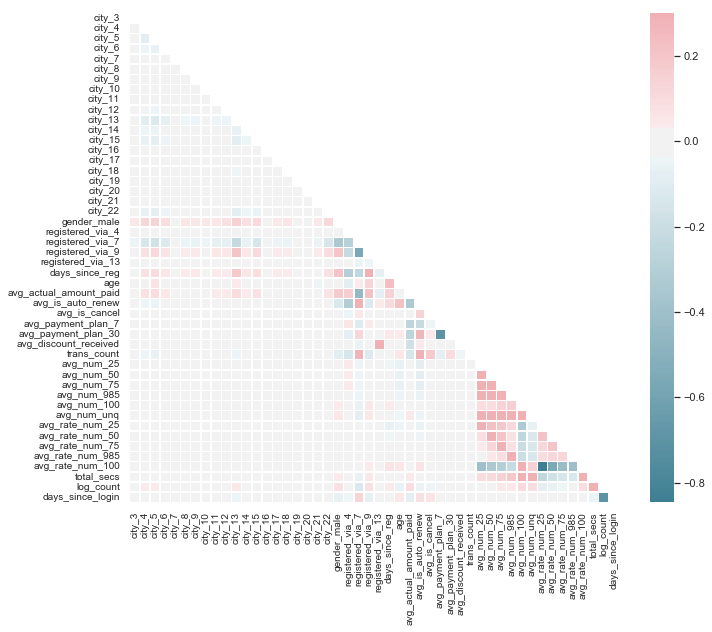

In [68]:
# Pairwise Correlation Heatmap
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = X_feb.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, mask=mask, center=0,
            square=True, linewidths=.5)
plt.yticks(np.arange(48)+0.5,list(corr.columns), rotation=0, fontsize="10", va="center")
plt.xticks(np.arange(48)+0.5,list(corr.columns), rotation='vertical', fontsize="10", va="top")
plt.show()

According to the pairwise correlation heatmap, there seems to be 3 highly, negatively correlated variables: 
* avg_payment_plan_30 and avg_payment_plan_7
* avg_rate_num_25 and avg_rate_num_100
* log_count and days_since_login. 

We will test to see which one of the correlated pairs should be taken out by keeping the variable that will give us the better score.

In [144]:
from collections import defaultdict
pairwise = [['avg_payment_plan_7', 'avg_payment_plan_30'], ['avg_rate_num_25', 'avg_rate_num_100'], ['log_count', 'days_since_login']]
drop = []
for pair in pairwise:
    compare = defaultdict(int)
    for col in pair:
        X_feb_1 = X_feb.drop(columns=[col])
        steps = [('scaler', StandardScaler()), ('GradientBoost', final_model)]
        pipeline = Pipeline(steps)
        pipeline.fit(X_feb_1, y_feb)
        cross_val_scores = cross_val_score(pipeline, X_feb_1, y_feb, cv=5, scoring='neg_log_loss')
        score = np.mean(cross_val_scores) * -1
        compare[col] = score
    best = min(compare.values())
    drop.extend([key for key, value in compare.items() if value == best])

print(drop)

['avg_payment_plan_7', 'avg_rate_num_25', 'log_count']


In [279]:
y_feb = feb_df.iloc[:,1]
X_feb = feb_df.iloc[:,2:]

In [269]:
drop = ['avg_payment_plan_30', 'avg_rate_num_25', 'days_since_login']
X_feb = X_feb.drop(columns = drop)
print(X_feb.shape)

(123815, 45)


In [270]:
final_model_lr = LogisticRegression(penalty='l2', C=1, max_iter = 100, dual=False)
steps = [('scaler', StandardScaler()),
         ('LogReg', final_model_lr)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb, y_feb)
pipeline.score(X_feb, y_feb)
y_pred_prob = pipeline.predict_proba(X_feb)[:,1]
log_loss(y_feb, y_pred_prob)

0.463304071412914

After dropping 3 variables that were highly correlated with the other variables in the training data, we are left with 45 variables.

Next, using Recursive Feature Elimination, we will remove more variables that does not benefit the model.

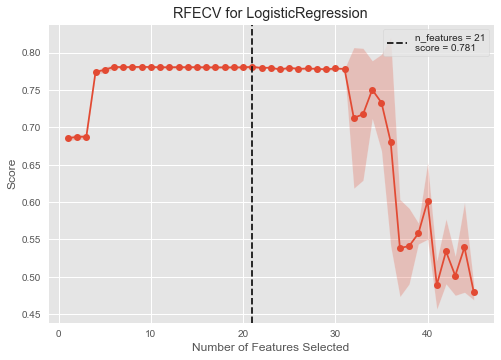

In [166]:
from yellowbrick.features import RFECV

viz = RFECV(final_model_lr)
viz.fit(X_feb, y_feb)
viz.poof()

According to the RFE graph, the ideal number of features to keep in the model is 21. 

In [272]:
from sklearn.feature_selection import RFE
rfe = RFE(final_model_lr, 21)
rfe = rfe.fit(X_feb, y_feb)
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True  True  True  True False False False False
 False  True False  True  True  True False False False False  True  True
  True False False False  True  True  True  True False  True False False
 False False False False  True  True  True  True  True False False False]
[18 12  8 15  1  1  1  1 23  5 13  7  4  1  3  1  1  1 26 10 11  6  1  1
  1 27 20 24  1  1  1  1 14  1 19 16  2 21 22 25  1  1  1  1  1 28  9 17]


In [273]:
d = {'Column name': X_feb.columns, 'Keep':rfe.support_}
keep = pd.DataFrame(d)
keep[keep.Keep == True]

,Column name,Keep
4,city_7,True
5,city_8,True
6,city_9,True
7,city_10,True
13,city_16,True
15,city_18,True
16,city_19,True
17,city_20,True
22,registered_via_7,True
23,registered_via_9,True


In [274]:
col_keep = list(keep[keep.Keep == True]['Column name'])
X_feb_rfe = X_feb[col_keep]
X_feb_rfe.shape

(123815, 21)

In [275]:
final_model_lr = LogisticRegression(penalty='l2', C=1, max_iter = 100, dual=False)
steps = [('scaler', StandardScaler()),
         ('LogReg', final_model_lr)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb_rfe, y_feb)
pipeline.score(X_feb_rfe, y_feb)
y_pred_prob = pipeline.predict_proba(X_feb_rfe)[:,1]
log_loss(y_feb, y_pred_prob)

0.4689883401663076

We can further improve the model by taking feature importance into account. Below, we use Mutual Information (MI) as a scoring method to rank each feature. Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [509]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

kbest = SelectKBest(score_func=mutual_info_classif, k=5)
kbest.fit(X_feb, y_feb)

feature_names = X_feb.columns
feature_scores = list(zip(feature_names, kbest.scores_))

feature_scores.sort(key=lambda x:x[1], reverse=True)

for item in feature_scores[:10]:
    print(f"Score of \"{item[0]}\": {round(item[1], 2)}")

Score of "avg_is_auto_renew": 0.19
Score of "trans_count": 0.15
Score of "avg_actual_amount_paid": 0.13
Score of "avg_is_cancel": 0.08
Score of "avg_payment_plan_7": 0.07
Score of "avg_discount_received": 0.06
Score of "registered_via_7": 0.06
Score of "avg_payment_plan_30": 0.03
Score of "age": 0.02
Score of "registered_via_4": 0.02


In [288]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
kbestscores = []

sc = StandardScaler()
X_feb_norm = sc.fit_transform(X_feb)

for rank in [18, 20, 24, 28, 30, 32]:
    kbest = SelectKBest(score_func=mutual_info_classif, \
                        k=rank)
    kbest.fit(X_feb_norm, y_feb)
    X_new = kbest.transform(X_feb_norm)

    final_model_lr.fit(X_new, y_feb)

    y_pred_prob = final_model_lr.predict_proba(X_new)[:,1]
    gbr_score = log_loss(y_feb, y_pred_prob)
    kbestscores.append((rank, gbr_score))

for item in kbestscores:
    print(f"Score with Only the Top {item[0]} Features: {round(item[1],4)}")

Score with Only the Top 18 Features: 0.4674
Score with Only the Top 20 Features: 0.4642
Score with Only the Top 24 Features: 0.4634
Score with Only the Top 28 Features: 0.4634
Score with Only the Top 30 Features: 0.4634
Score with Only the Top 32 Features: 0.4634


In [290]:
kbest = SelectKBest(score_func=mutual_info_classif, k=24)
sc = StandardScaler()
X_feb_norm = sc.fit_transform(X_feb)
kbest.fit(X_feb_norm, y_feb)

feature_names = X_feb.columns
feature_scores = list(zip(feature_names, kbest.scores_))

feature_scores.sort(key=lambda x:x[1], reverse=True)

for item in feature_scores[:24]:
    print(f"Score of \"{item[0]}\": {round(item[1], 5)}")

Score of "avg_is_auto_renew": 0.19018
Score of "trans_count": 0.14505
Score of "avg_actual_amount_paid": 0.1238
Score of "avg_is_cancel": 0.08851
Score of "avg_payment_plan_7": 0.07506
Score of "avg_discount_received": 0.06431
Score of "registered_via_7": 0.06106
Score of "age": 0.02307
Score of "registered_via_4": 0.02025
Score of "avg_payment_plan_30": 0.01582
Score of "days_since_reg": 0.01378
Score of "registered_via_9": 0.01153
Score of "gender_male": 0.01058
Score of "city_14": 0.0058
Score of "city_5": 0.00558
Score of "city_4": 0.00551
Score of "log_count": 0.00467
Score of "city_15": 0.00422
Score of "city_13": 0.00422
Score of "city_12": 0.00416
Score of "avg_num_985": 0.00403
Score of "city_17": 0.00383
Score of "avg_rate_num_25": 0.00382
Score of "city_6": 0.00382


In [295]:
feature_kbest = pd.DataFrame({'Feature': X_feb.columns, 'MI Score': kbest.scores_})
feature_kbest = feature_kbest.sort_values(by='MI Score', ascending = False)
feature_kbest.iloc[:24,:]

,Feature,MI Score
28,avg_is_auto_renew,0.190177
33,trans_count,0.145051
27,avg_actual_amount_paid,0.123797
29,avg_is_cancel,0.088513
30,avg_payment_plan_7,0.075063
32,avg_discount_received,0.064310
22,registered_via_7,0.061058
26,age,0.023075
21,registered_via_4,0.020251
31,avg_payment_plan_30,0.015818


In [301]:
keep_mi = list(feature_kbest.Feature[:24])
X_feb_mi = X_feb[keep_mi]
X_feb_mi.shape

(123815, 24)

In [302]:
final_model_lr = LogisticRegression(penalty='l2', C=1, max_iter = 100, dual=False)
steps = [('scaler', StandardScaler()),
         ('LogReg', final_model_lr)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb_mi, y_feb)
pipeline.score(X_feb_mi, y_feb)
y_pred_prob = pipeline.predict_proba(X_feb_mi)[:,1]
log_loss(y_feb, y_pred_prob)

0.46393003621986717

## PCA (Dimension Reduction)

In [342]:
# Normalize feature set
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_feb)
X_test = sc.transform(X_march)

# Applying PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)  

# PCA CDF
#explained_variance = pca.explained_variance_ratio_     
#pca_df = pd.DataFrame(list(zip(range(1,49), np.cumsum(explained_variance))), columns = ['number', 'explained_variance'])

# Plot CDF
#plt.plot(np.cumsum(explained_variance), marker='o', alpha = 0.5)
#plt.title('CDF of PCA')
#plt.xlabel('# of PCA components')
#plt.ylabel('CDF')
#plt.show()

### Recursive Feature Elimination

In [351]:
X_feb_rfe['PCA_1'] = X_train_pca.T[0]
X_feb_rfe['PCA_2'] = X_train_pca.T[1]

In [354]:
X_feb_rfe.columns

Index(['city_7', 'city_8', 'city_9', 'city_10', 'city_16', 'city_18',
       'city_19', 'city_20', 'registered_via_7', 'registered_via_9',
       'registered_via_13', 'avg_is_auto_renew', 'avg_is_cancel',
       'avg_payment_plan_7', 'avg_payment_plan_30', 'trans_count',
       'avg_rate_num_25', 'avg_rate_num_50', 'avg_rate_num_75',
       'avg_rate_num_985', 'avg_rate_num_100', 'PCA_1', 'PCA_2'],
      dtype='object')

In [355]:
final_model_lr = LogisticRegression(penalty='l2', C=1, max_iter = 100, dual=False)
steps = [('scaler', StandardScaler()),
         ('LogReg', final_model_lr)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb_rfe, y_feb)
pipeline.score(X_feb_rfe, y_feb)
y_pred_prob = pipeline.predict_proba(X_feb_rfe)[:,1]
log_loss(y_feb, y_pred_prob)

0.46772773329929185

### Feature Importance

In [358]:
X_feb_mi['PCA_1'] = X_train_pca.T[0]
X_feb_mi['PCA_2'] = X_train_pca.T[1]
final_model_lr = LogisticRegression(penalty='l2', C=1, max_iter = 100, dual=False)
steps = [('scaler', StandardScaler()),
         ('LogReg', final_model_lr)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb_mi, y_feb)

y_pred_prob = pipeline.predict_proba(X_feb_mi)[:,1]
log_loss(y_feb, y_pred_prob)

0.46372820195598996

In [359]:
pipeline.score(X_feb_mi, y_feb)

0.8129225053507249

## Fitting the Final Model

### XgBoosting Algorithm

Train Data

In [362]:
final_model = XGBClassifier(max_depth = 8, learning_rate = 0.05, colsample_bytree = 0.8)
steps = [('scaler', StandardScaler()),
         ('Boosting', final_model)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb_mi, y_feb)

y_pred_prob = pipeline.predict_proba(X_feb_mi)[:,1]
log_loss(y_feb, y_pred_prob)

print(f'Accuracy score: {pipeline.score(X_feb_mi, y_feb)}')
print(f'Log Loss: {log_loss(y_feb, y_pred_prob)}')

Accuracy score: 0.8367079917619028
Log Loss: 0.39525463964417923


Test Data

In [363]:
X_march_mi = X_march[keep_mi]
X_march_mi['PCA_1'] = X_test_pca.T[0]
X_march_mi['PCA_2'] = X_test_pca.T[1]

In [365]:
y_pred_prob = pipeline.predict_proba(X_march_mi)[:,1]
log_loss(y_march, y_pred_prob)

print(f'Accuracy score: {pipeline.score(X_march_mi, y_march)}')
print(f'Log Loss: {log_loss(y_march, y_pred_prob)}')

Accuracy score: 0.8027438851549262
Log Loss: 0.45585536221947004


### Logistic Regression

Train Data

In [366]:
final_model_lr = LogisticRegression(penalty='l2', C=1, max_iter = 100, dual=False)
steps = [('scaler', StandardScaler()),
         ('LogReg', final_model_lr)]
pipeline = Pipeline(steps)
pipeline.fit(X_feb_mi, y_feb)

y_pred_prob = pipeline.predict_proba(X_feb_mi)[:,1]
log_loss(y_feb, y_pred_prob)

print(f'Accuracy score: {pipeline.score(X_feb_mi, y_feb)}')
print(f'Log Loss: {log_loss(y_feb, y_pred_prob)}')

Accuracy score: 0.8129225053507249
Log Loss: 0.46372820195598996


Test Data

In [367]:
y_pred_prob = pipeline.predict_proba(X_march_mi)[:,1]
log_loss(y_march, y_pred_prob)

print(f'Accuracy score: {pipeline.score(X_march_mi, y_march)}')
print(f'Log Loss: {log_loss(y_march, y_pred_prob)}')

Accuracy score: 0.8015785528462455
Log Loss: 0.4717696678497034
